# The Long and Short of Fama-French Momentum

Most investors are long-only and do not have access to investment vehicles that go short. However, academic factor investing focuses mostly on long-short portfolios to show their persistence. The contribution of the short-side of the portfolio to aggregate performance cannot be trivialized. Here, we construct three portfolios out of the Fama-French Momentum data-set -- long-only, short-only and long-short -- to get an idea of how they intersect.

The [Fama-French](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_10_port_form_pr_12_2_daily.html) data-set has returns for portfolios constructed out of each decile of prior returns. With **HI_PRIOR** and **LO_PRIOR** returns, long-only, long-short and short-only portfolio daily returns can be calculated. These returns can then be compared with market returns contained in the [5 Factors (2x3)](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html) data-set by adding back the **Rf** to **Rm-Rf**.

The documentation for the Fama-French data-set can be found [here](https://plutopy.readthedocs.io/en/latest/FamaFrench.html) and [here](https://shyams80.github.io/plutoR/docs/reference/FamaFrench-class.html)

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")

#initialize
famaFrench <- FamaFrench()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from

In [2]:
momStartDt <- (famaFrench$MomentumDaily() %>% summarize(MAX = min(TIME_STAMP)) %>% collect())$MAX[[1]]
mktStartDt <- (famaFrench$FiveFactor3x2Daily() %>% summarize(MAX = min(TIME_STAMP)) %>% collect())$MAX[[1]]
startDt <- max(momStartDt, mktStartDt)

hiMom <- famaFrench$MomentumDaily() %>%
    filter(KEY_ID == 'HI_PRIOR' & TIME_STAMP >= startDt) %>%
    select(TIME_STAMP, RET) %>%
    collect() %>%
    as.data.frame()

loMom <- famaFrench$MomentumDaily() %>%
    filter(KEY_ID == 'LO_PRIOR' & TIME_STAMP >= startDt) %>%
    select(TIME_STAMP, RET) %>%
    collect() %>%
    as.data.frame()

mktRet <- famaFrench$FiveFactor3x2Daily() %>%
    inner_join(famaFrench$FiveFactor3x2Daily(), by=c('TIME_STAMP')) %>%
    filter(KEY_ID.x == 'MKT-RF' & KEY_ID.y == 'RF' & TIME_STAMP >= startDt) %>%
    mutate(R = RET.x + RET.y) %>%
    select(TIME_STAMP, R) %>%
    collect() %>%
    as.data.frame()

Warning message:
“Missing values are always removed in SQL.
Use `MIN(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

In [3]:
retXts <- merge(xts(hiMom$RET, hiMom$TIME_STAMP), xts(loMom$RET, loMom$TIME_STAMP), xts(mktRet$R, mktRet$TIME_STAMP))
retXts <- na.omit(retXts)
retXts <- retXts/100

names(retXts) <- c('HI', 'LO', 'MKT')

print(head(retXts))
print(tail(retXts))

                HI      LO      MKT
1963-07-01 -0.0098 -0.0056 -0.00658
1963-07-02  0.0141  0.0020  0.00802
1963-07-03  0.0083  0.0049  0.00642
1963-07-05  0.0044  0.0042  0.00412
1963-07-08 -0.0092 -0.0039 -0.00618
1963-07-09  0.0117  0.0013  0.00462
                HI      LO      MKT
2019-06-21 -0.0040 -0.0064 -0.00201
2019-06-24 -0.0093 -0.0169 -0.00331
2019-06-25 -0.0115 -0.0054 -0.00971
2019-06-26 -0.0066  0.0055 -0.00051
2019-06-27  0.0185  0.0143  0.00609
2019-06-28  0.0160  0.0095  0.00689


In [4]:
longOnly <- merge(retXts$HI, retXts$MKT)
names(longOnly) <- c('L', 'MKT')

shortOnly <- merge(-retXts$LO, retXts$MKT)
names(shortOnly) <- c('S', 'MKT')

longShort <- merge(retXts$HI-retXts$LO, retXts$MKT)
names(longShort) <- c('LS', 'MKT')

lsl <- merge(retXts$HI, -retXts$LO, retXts$HI-retXts$LO, retXts$MKT)
names(lsl) <- c('L', 'S', 'LS', 'MKT')

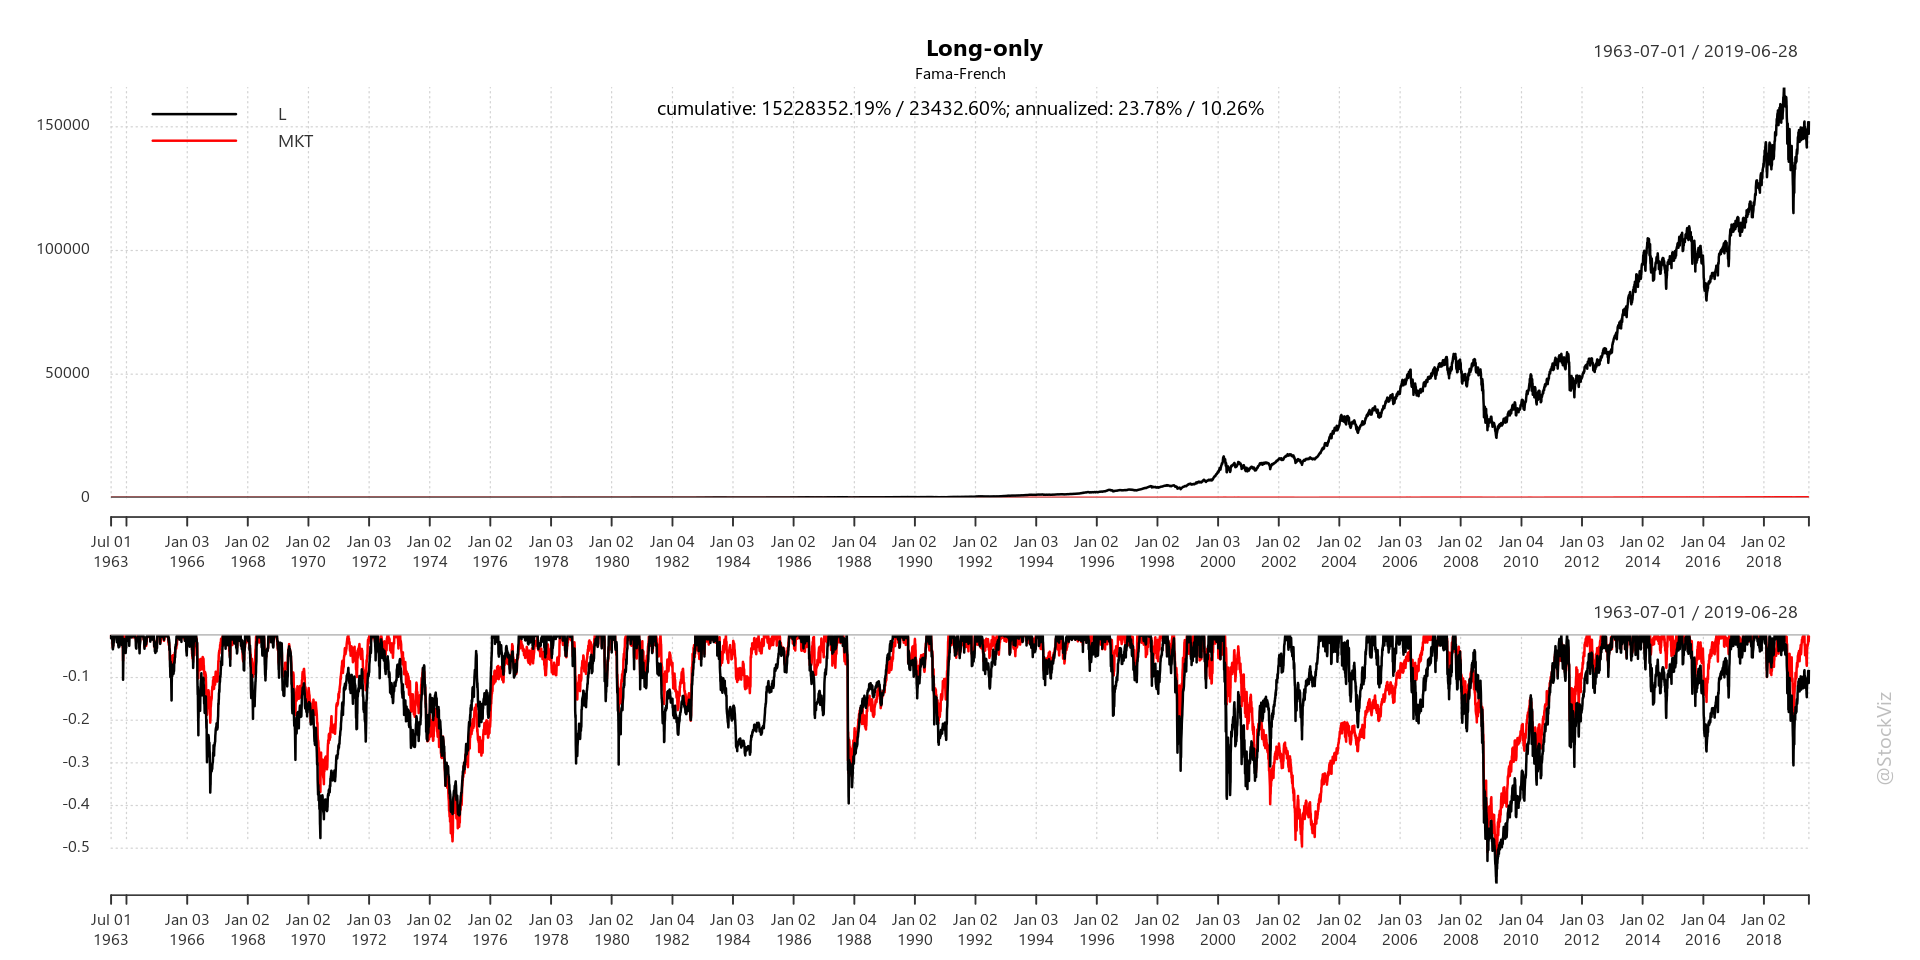

In [5]:
Common.PlotCumReturns(longOnly, "Long-only", "Fama-French")

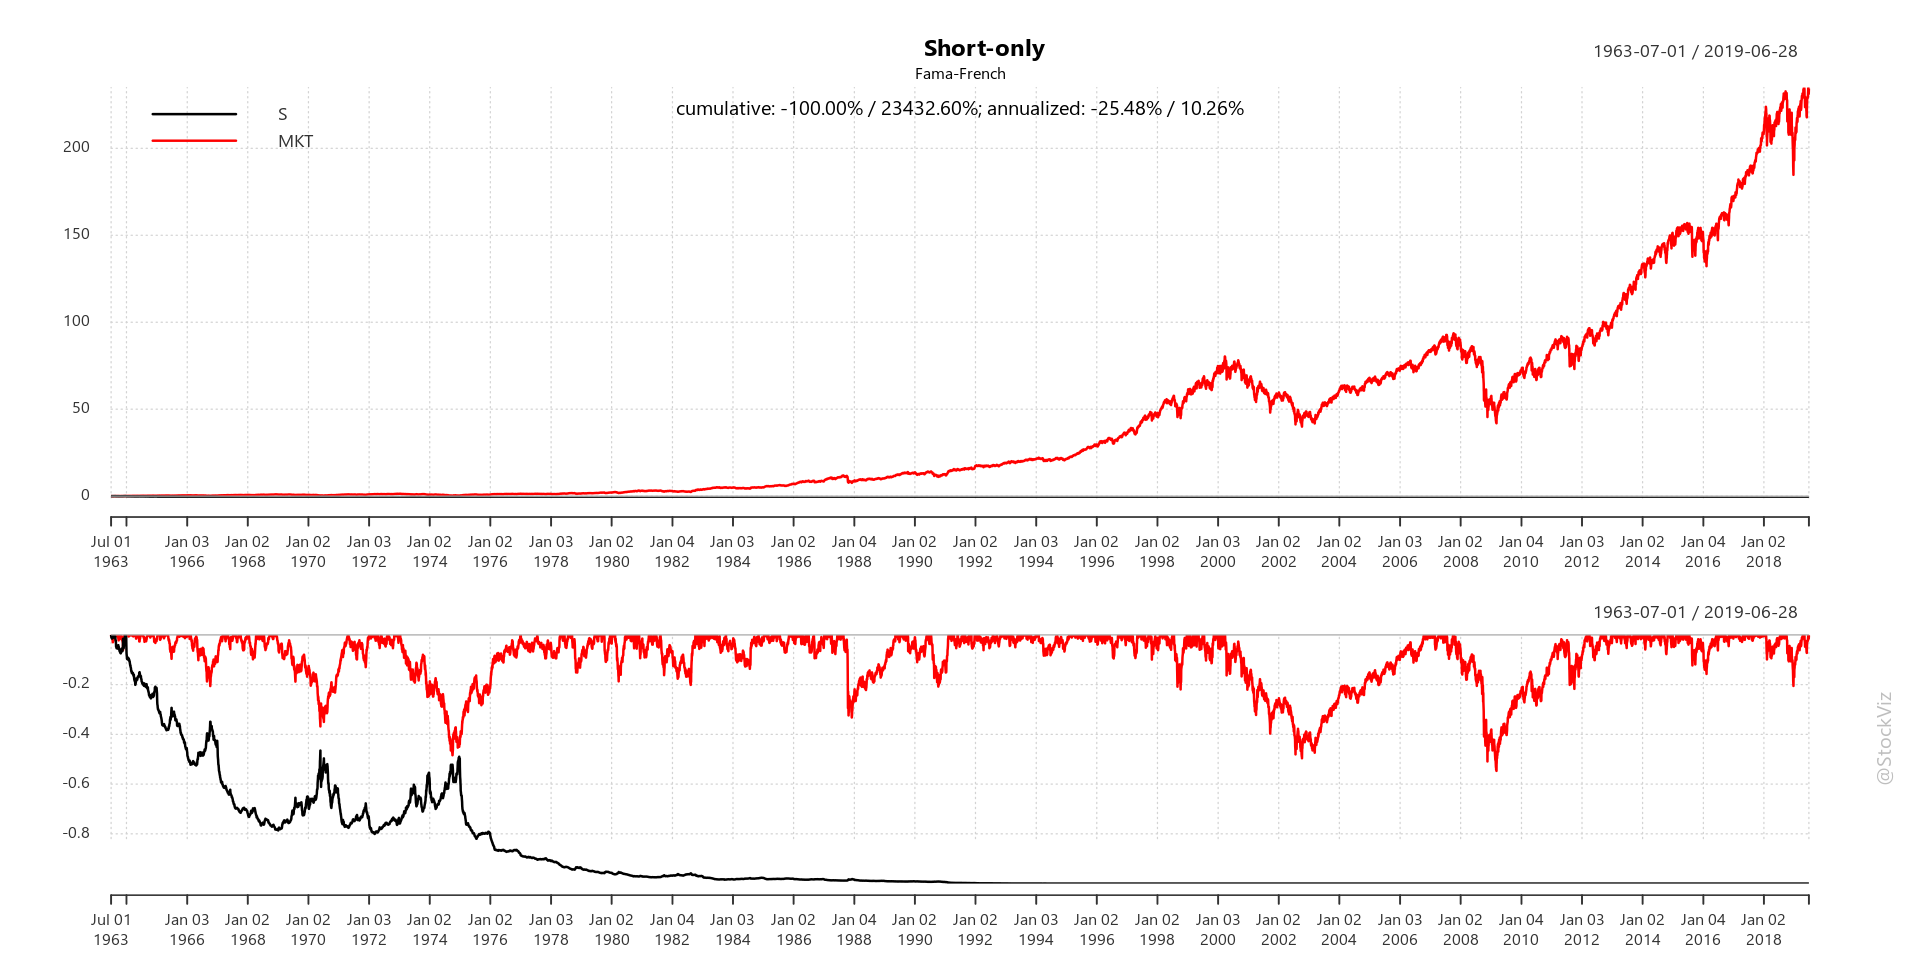

In [6]:
Common.PlotCumReturns(shortOnly, "Short-only", "Fama-French")

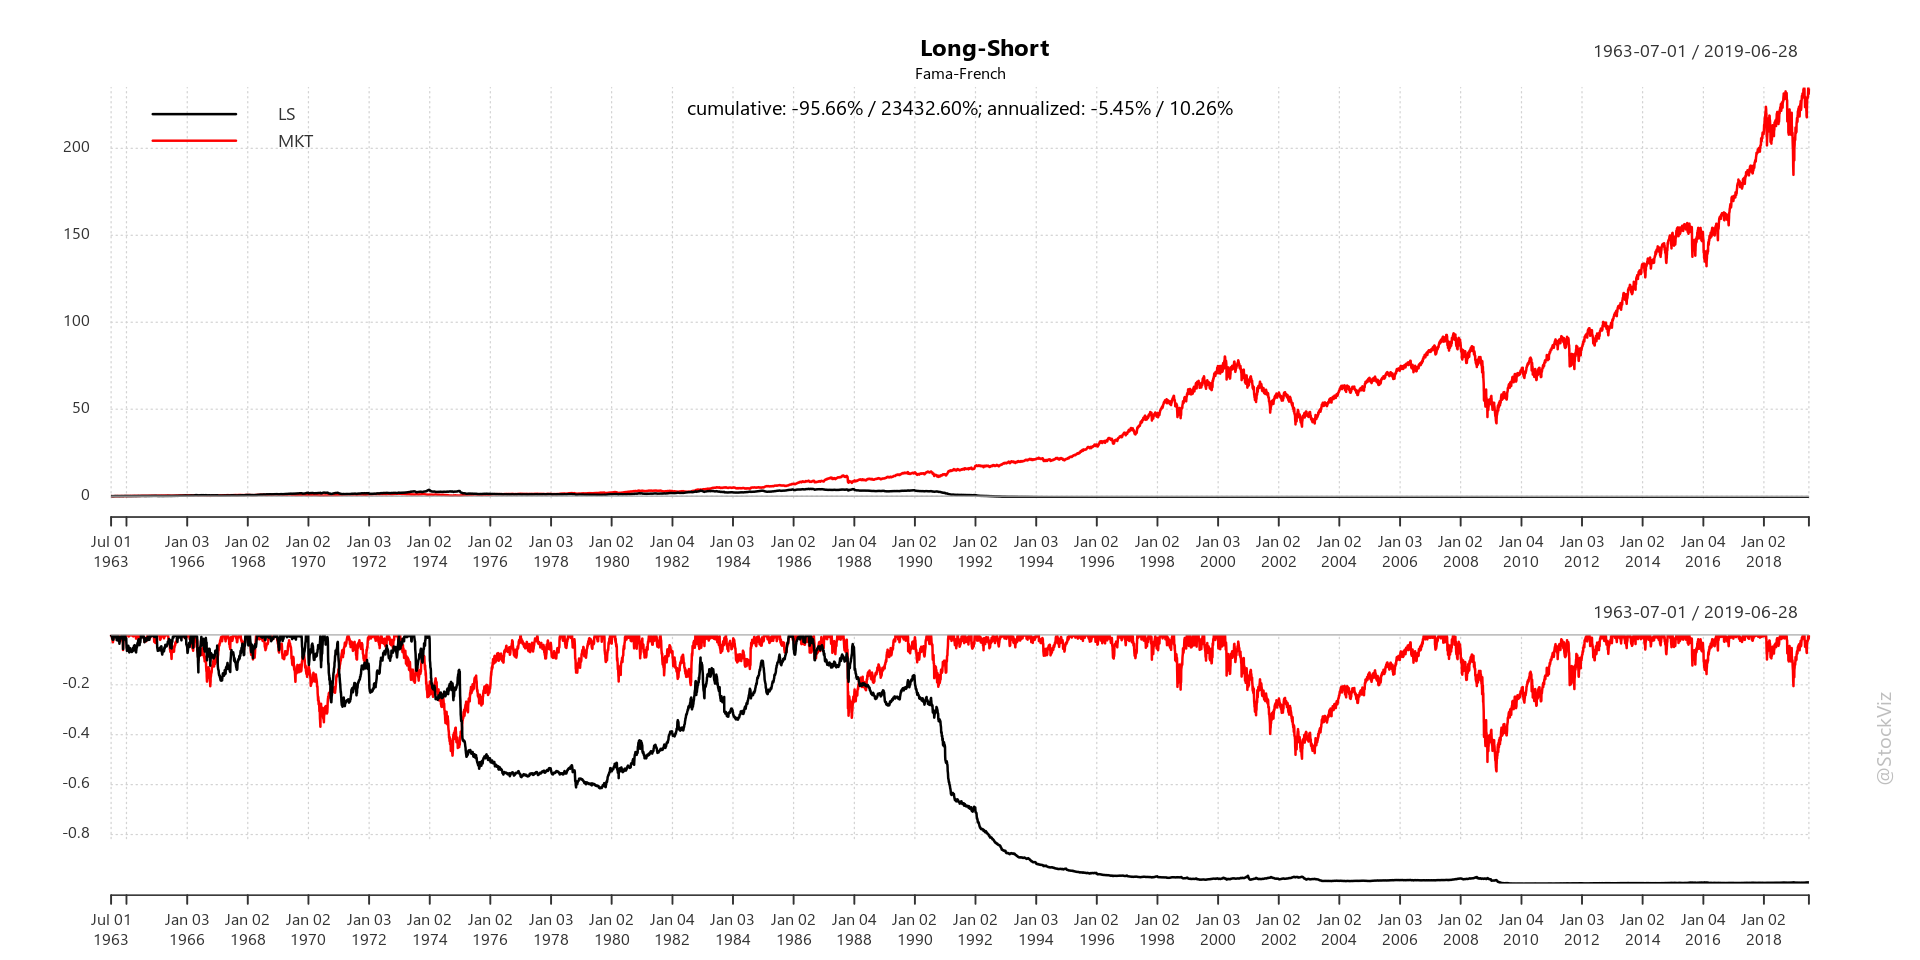

In [7]:
Common.PlotCumReturns(longShort, "Long-Short", "Fama-French")

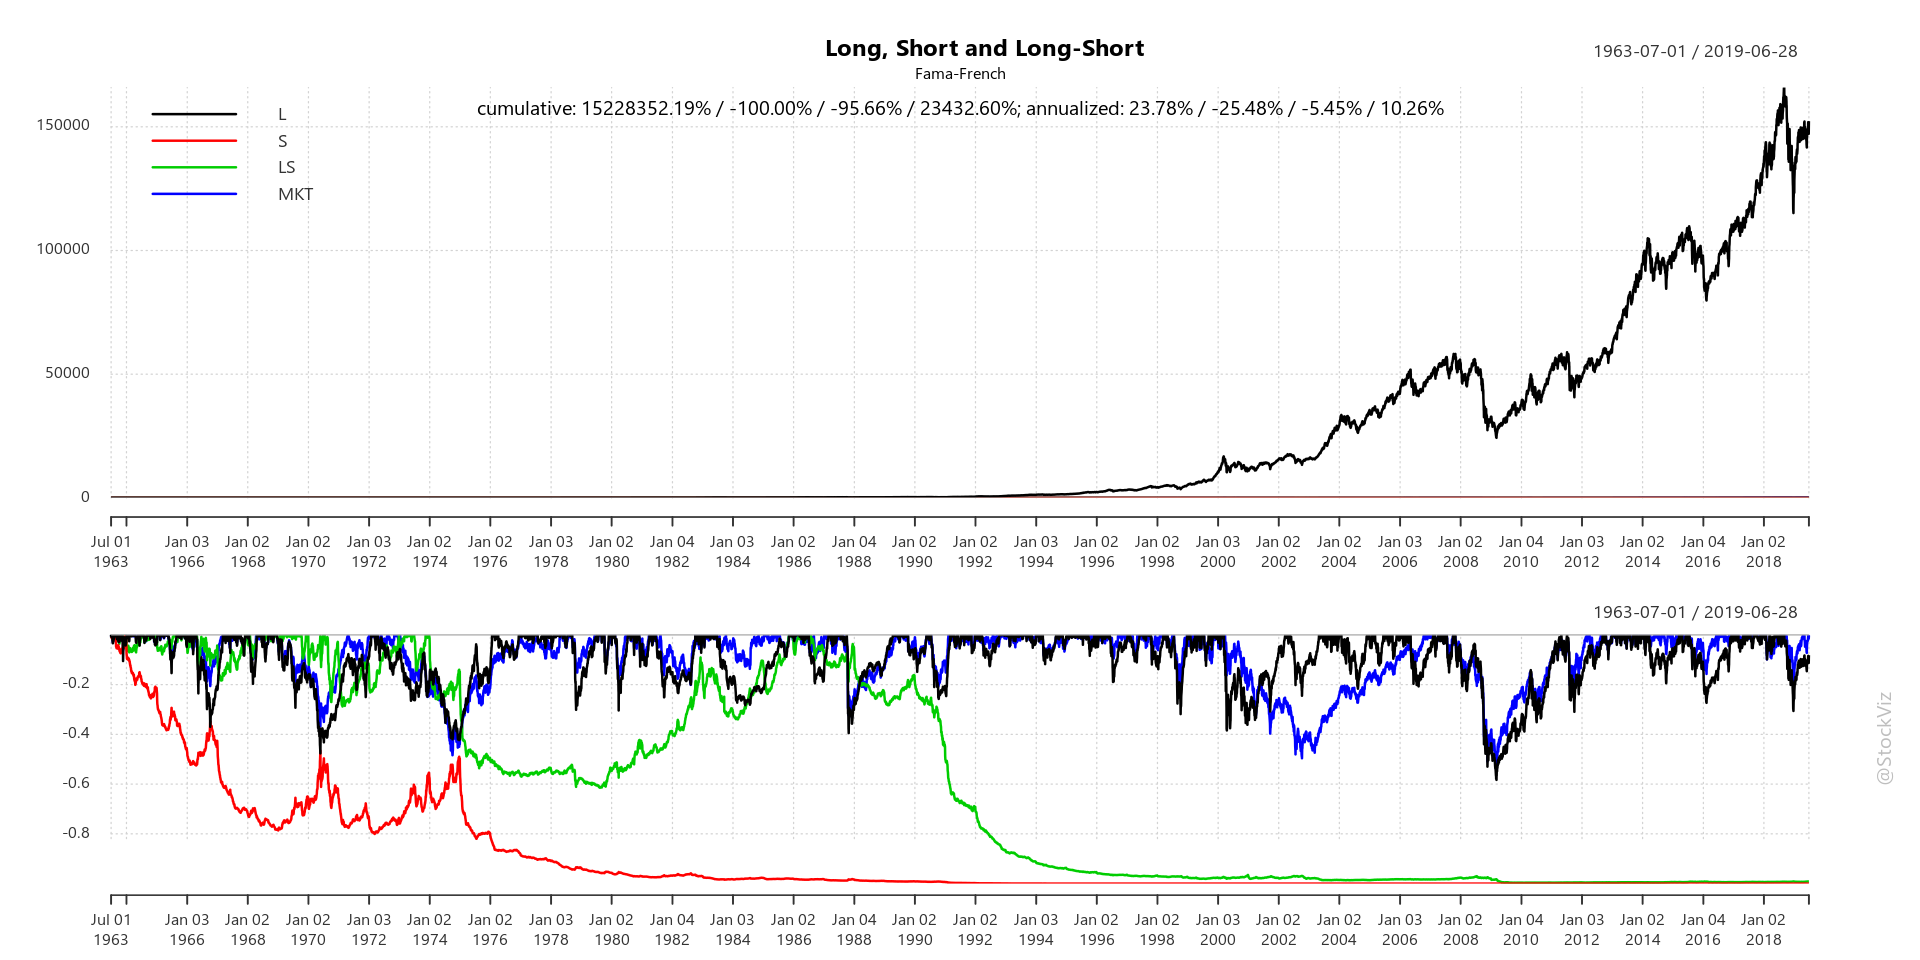

In [8]:
Common.PlotCumReturns(lsl, "Long, Short and Long-Short", "Fama-French")

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)